<a href="https://www.kaggle.com/code/ahmettalhabektas/proactive-maintenance-predicting-failures-with-ml?scriptVersionId=153692457" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import necessary libraries

In [1]:
import pandas as pd  # Pandas for data manipulation
import pandas_profiling

import matplotlib.pyplot as plt  # Matplotlib for data visualization
%matplotlib inline
import numpy as np  # NumPy for numerical operations
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import seaborn as sns  # Seaborn for data visualization

# Import machine learning models
from sklearn.naive_bayes import GaussianNB, BernoulliNB  # For binary classification
from sklearn.naive_bayes import MultinomialNB  # For multi-class classification
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors classifier
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree classifier
from sklearn.linear_model import LogisticRegression  # Logistic Regression classifier
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting classifier

# Import machine learning evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Import tools for data splitting
from sklearn.model_selection import train_test_split



/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_19/1975560345.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling

### Read the dataset from "failure.csv" into a DataFrame


In [2]:
# Read the dataset from "failure.csv" into a DataFrame
filename = "/kaggle/input/predictive-maintenance-dataset/predictive_maintenance_dataset.csv"
df = pd.read_csv(filename)


## EDA 

In [3]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df.shape

(124494, 12)

In [5]:
df.drop_duplicates(inplace=True)
df.shape

(124493, 12)

For skewed data, you can consider applying transformations such as logarithmic transformations to make the distribution more symmetric. 

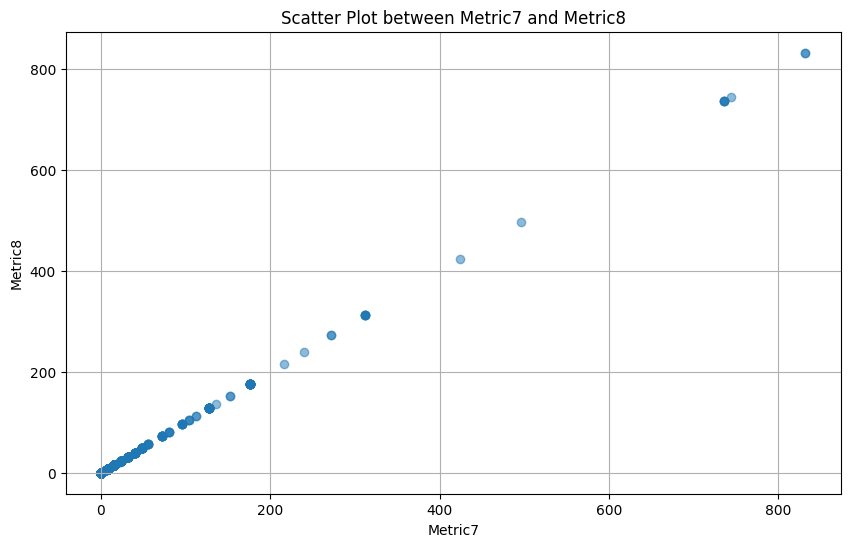

In [6]:
# Scatter plot using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(df['metric7'], df['metric8'], alpha=0.5)
plt.title('Scatter Plot between Metric7 and Metric8')
plt.xlabel('Metric7')
plt.ylabel('Metric8')
plt.grid(True)
plt.show()

In [7]:
for num in ["2","3","4","7","8","9"]:
    df[f'metric{num}'] = np.log1p(df[f'metric{num}'])

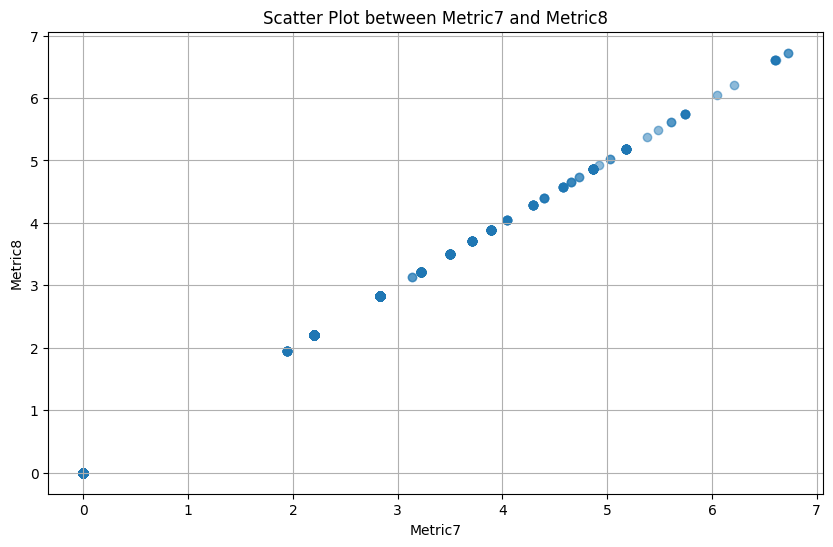

In [8]:
# Scatter plot using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(df['metric7'], df['metric8'], alpha=0.5)
plt.title('Scatter Plot between Metric7 and Metric8')
plt.xlabel('Metric7')
plt.ylabel('Metric8')
plt.grid(True)
plt.show()

metric 7 and metric 8 is almost same values so I will drop metric 8. 

In [9]:
df.drop("metric8",axis=1,inplace=True)

In [10]:
def summarize_data(df):
    print("Number of rows and columns:", df.shape)
    print("\nColumns in the dataset:", df.columns)
    print("\nData types and missing values:")
    print(df.info())
    print("\nSummary statistics for numerical columns:")
    print(df.describe())
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nUnique values in 'failure' column:")
    print(df['failure'].value_counts())

# Call the function to summarize the data
summarize_data(df)


Number of rows and columns: (124493, 11)

Columns in the dataset: Index(['date', 'device', 'failure', 'metric1', 'metric2', 'metric3', 'metric4',
       'metric5', 'metric6', 'metric7', 'metric9'],
      dtype='object')

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 124493 entries, 0 to 124493
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   date     124493 non-null  object 
 1   device   124493 non-null  object 
 2   failure  124493 non-null  int64  
 3   metric1  124493 non-null  int64  
 4   metric2  124493 non-null  float64
 5   metric3  124493 non-null  float64
 6   metric4  124493 non-null  float64
 7   metric5  124493 non-null  int64  
 8   metric6  124493 non-null  int64  
 9   metric7  124493 non-null  float64
 10  metric9  124493 non-null  float64
dtypes: float64(5), int64(4), object(2)
memory usage: 11.4+ MB
None

Summary statistics for numerical columns:
             failure    

We do not have any null values, but we have a very small number of positive samples for the target variable, indicating an undersampling problem.


In [11]:
df["device"]

0         S1F01085
1         S1F0166B
2         S1F01E6Y
3         S1F01JE0
4         S1F01R2B
            ...   
124489    Z1F0MA1S
124490    Z1F0Q8RT
124491    Z1F0QK05
124492    Z1F0QL3N
124493    Z1F0QLC1
Name: device, Length: 124493, dtype: object

It seems like there is apattern with first 4 letter. so I will create a new column with these values.

In [12]:
df["device_model"]=df["device"].apply(lambda x : x[:4])
df["device_model"].value_counts()

device_model
S1F0    33168
W1F0    23294
S1F1    21689
W1F1    19974
Z1F0    18869
Z1F1     7248
Z1F2      251
Name: count, dtype: int64

What about rest of them ?

In [13]:
df["device_rest"]=df["device"].apply(lambda x : x[4:])
df["device_rest"].value_counts()[:20]

device_rest
QLC1    304
KYCR    304
E9EP    304
EGMT    304
FGBQ    304
FP0C    304
GCED    304
GGPP    304
5X69    304
GPXY    304
H6JG    304
FEH7    304
MA1S    304
FY92    304
FZPA    304
G9T7    304
JH87    304
JXDL    304
JY02    304
GB8A    304
Name: count, dtype: int64

In [14]:
df.drop("device",axis=1,inplace=True)

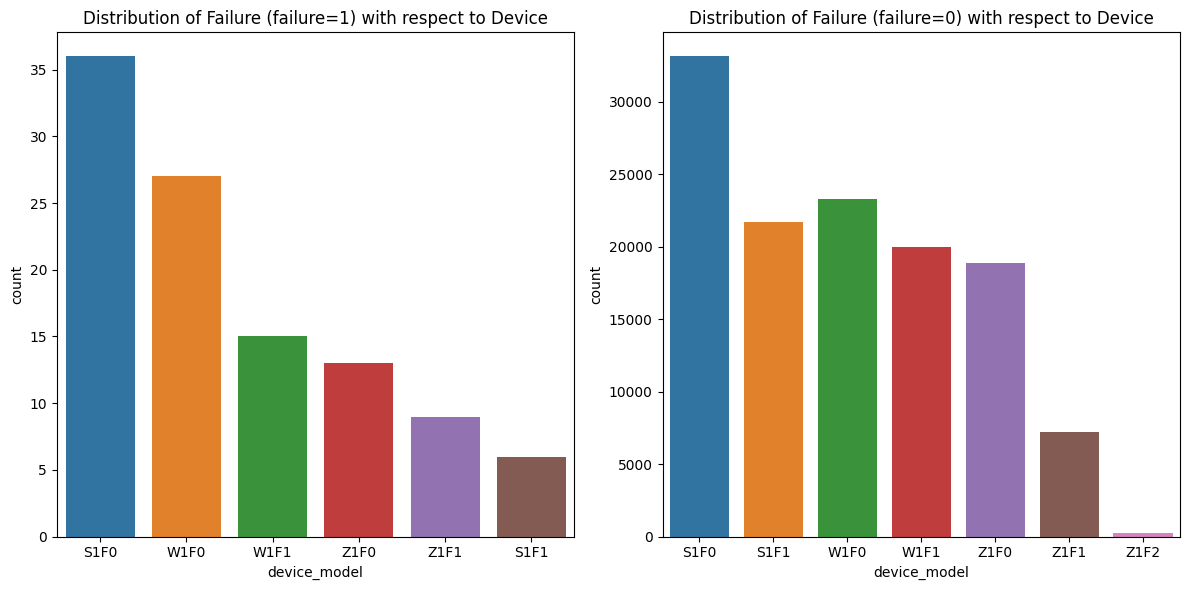

In [15]:
# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 6))
# Plot the distribution of 'failure' with respect to 'device' for failure=1
plt.subplot(1, 2, 1)
sns.countplot(x="device_model", data=df.loc[df["failure"] == 1])
plt.title('Distribution of Failure (failure=1) with respect to Device')

# Plot the distribution of 'failure' with respect to 'device' for failure=0
plt.subplot(1, 2, 2)
sns.countplot(x="device_model", data=df.loc[df["failure"] == 0])
plt.title('Distribution of Failure (failure=0) with respect to Device')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

Since there is no Z1F2 in target we could drop it for better results.

In [16]:
df.drop(df.loc[df["device_model"]=="Z1F2"].index,axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)
df.tail()

date  failure    metric1   metric2   metric3   metric4  metric5  \
124237  11/2/2015        0   18310224  0.000000  0.000000  0.000000       10   
124238  11/2/2015        0  172556680  4.574711  4.682131  1.609438       11   
124239  11/2/2015        0   19029120  8.483223  0.000000  0.000000       11   
124240  11/2/2015        0  226953408  0.000000  0.000000  0.000000       12   
124241  11/2/2015        0   17572840  0.000000  0.000000  0.000000       10   

        metric6   metric7    metric9 device_model device_rest  
124237   353705  2.197225   0.000000         Z1F0        MA1S  
124238   332792  0.000000   2.639057         Z1F0        Q8RT  
124239   350410  0.000000   0.000000         Z1F0        QK05  
124240   358980  0.000000   0.000000         Z1F0        QL3N  
124241   351431  0.000000  11.156265         Z1F0        QLC1

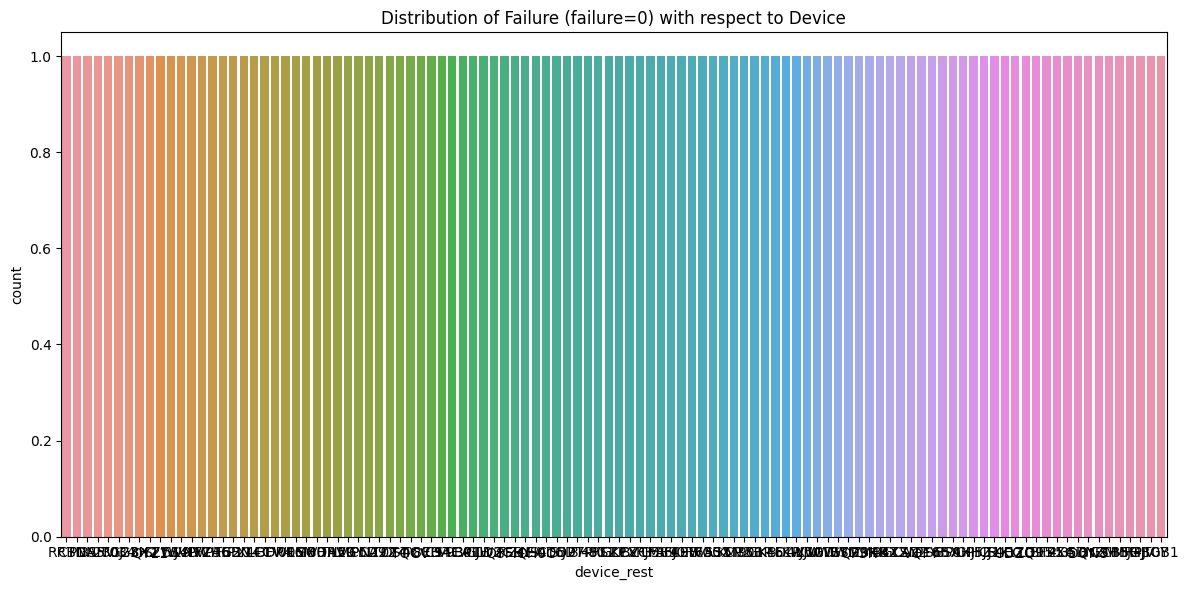

In [17]:
# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 6))
sns.countplot(x="device_rest", data=df.loc[df["failure"] == 1])
plt.title('Distribution of Failure (failure=0) with respect to Device')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

Since Distrubtion of device column rest of it is 1 in target, it is useless for us . I will drop it  

In [18]:
df.drop("device_rest",axis=1,inplace=True)
df.sample(5)

date  failure    metric1  metric2  metric3  metric4  metric5  \
106607  7/26/2015        0   34940488      0.0      0.0      0.0        8   
114523  8/20/2015        0   24117760      0.0      0.0      0.0        8   
84535   5/23/2015        0   39089800      0.0      0.0      0.0       10   
96777   6/27/2015        0  116112296      0.0      0.0      0.0        7   
18136   1/22/2015        0  171016784      0.0      0.0      0.0        8   

        metric6  metric7   metric9 device_model  
106607   512731      0.0  0.000000         W1F0  
114523   240080      0.0  0.000000         Z1F1  
84535    228632      0.0  1.609438         W1F1  
96777        30      0.0  0.000000         W1F1  
18136    212334      0.0  0.000000         S1F1

In [19]:
# Visualize pair plots for selected metrics with 'failure' as hue
#sns.pairplot(df, hue='failure', vars=['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric9'])


Distribution for failure is 0


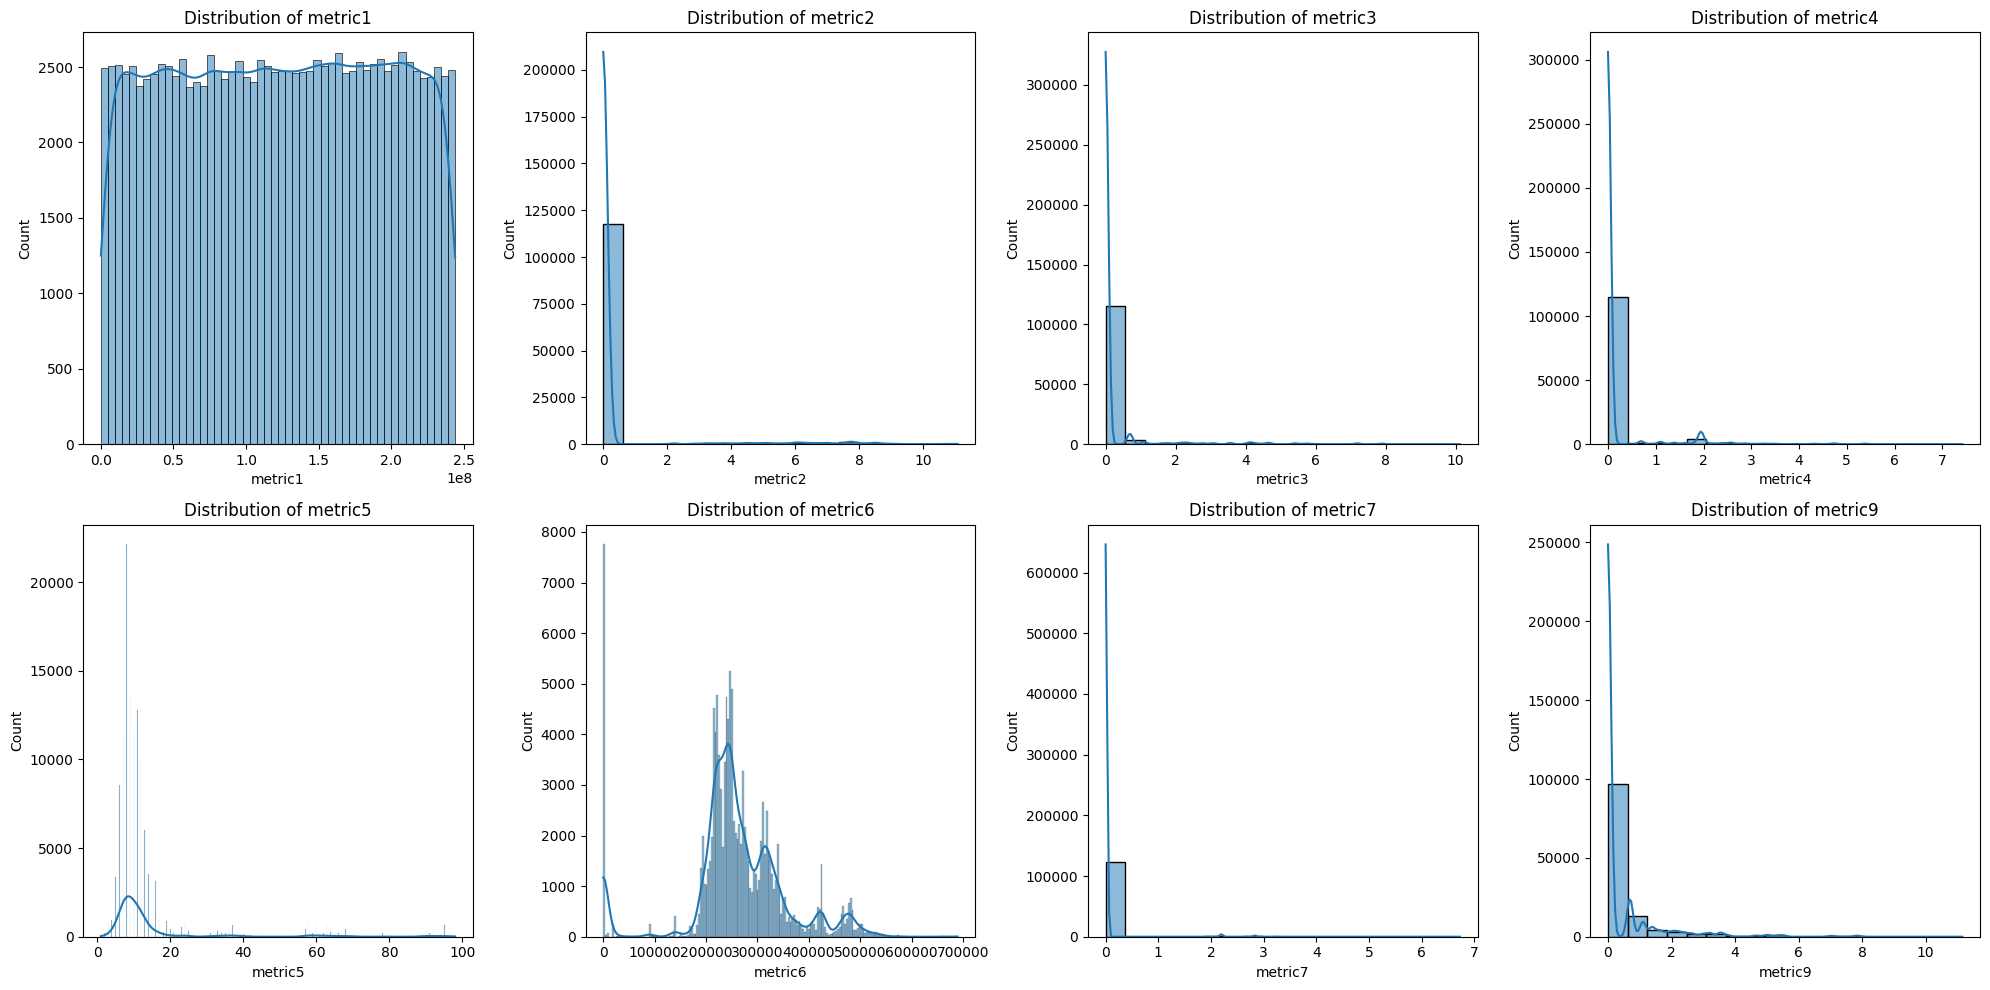

In [20]:
# Create histograms to visualize the distribution of selected metrics with 'failure' as hue
plt.figure(figsize=(4*5, 2*5))
print("Distribution for failure is 0")
mask= df.failure==0
for i, col in enumerate(['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7',  'metric9']):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data=df.loc[mask], x=col, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()

Distribution for failure is 1


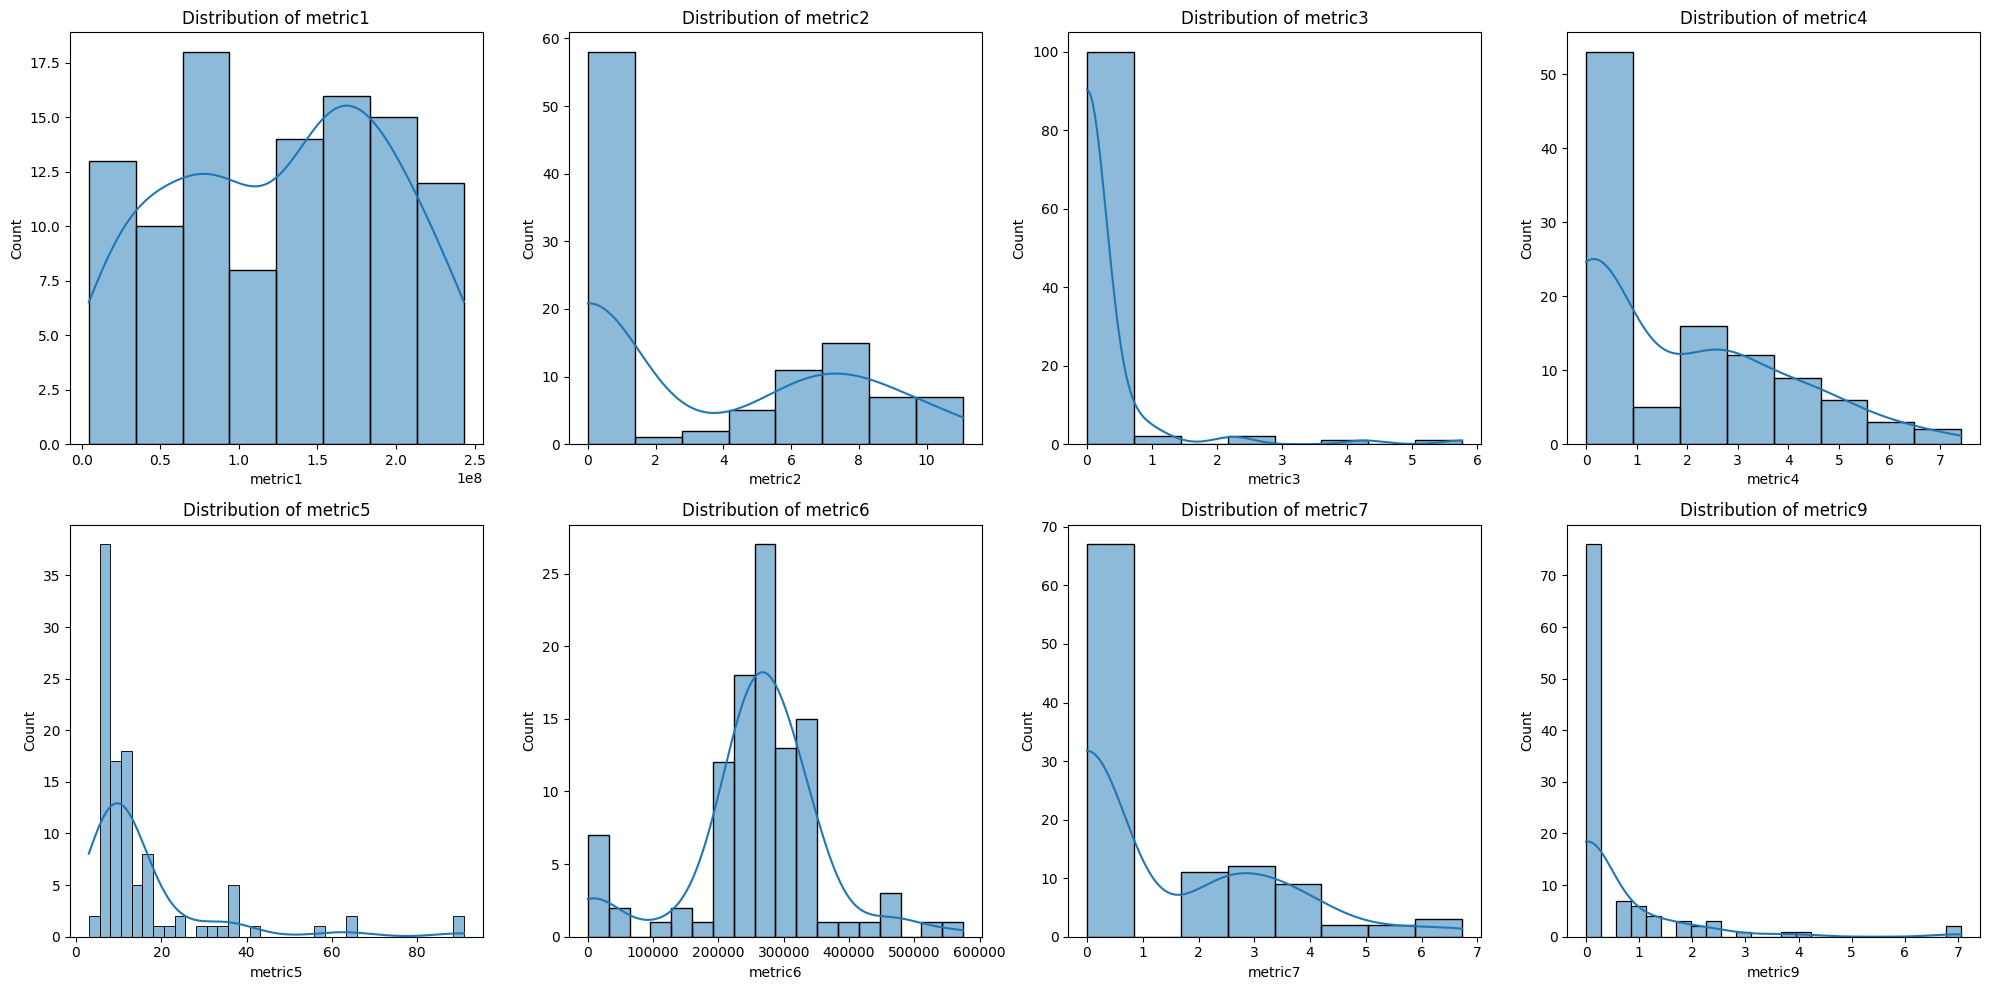

In [21]:
# Create histograms to visualize the distribution of selected metrics with 'failure' as hue
plt.figure(figsize=(20, 10))
print("Distribution for failure is 1")
mask= df.failure>0
for i, col in enumerate(['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric9']):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data=df.loc[mask], x=col, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()

Text(0.5, 1.0, 'Failure over Time by Month')

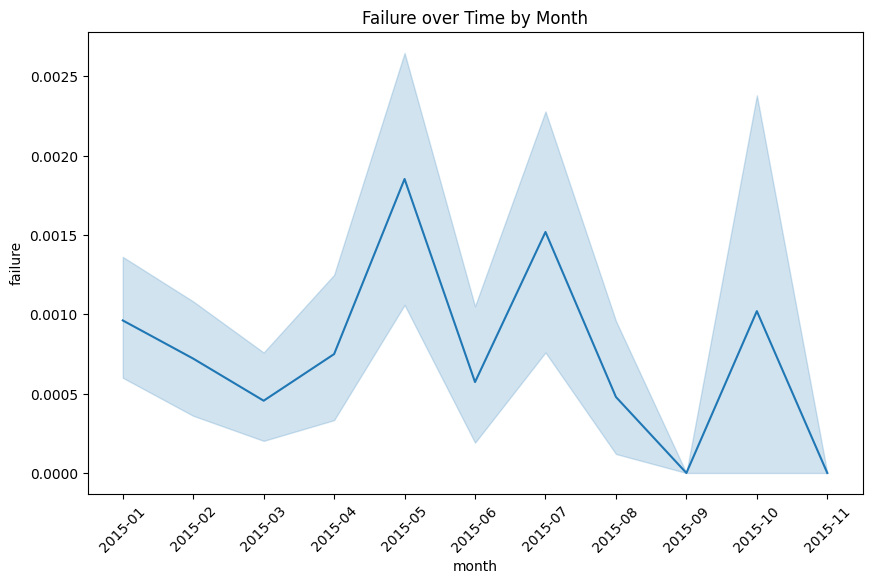

In [22]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract and format the 'month' column for plotting
df['month'] = df['date'].dt.to_period('M')
df['month'] = df['month'].dt.strftime('%Y-%m')

# Create a line plot to visualize 'failure' over time by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month', y='failure')
plt.xticks(rotation=45)
plt.title("Failure over Time by Month")


Text(0.5, 1.0, 'Failure over Time by Week')

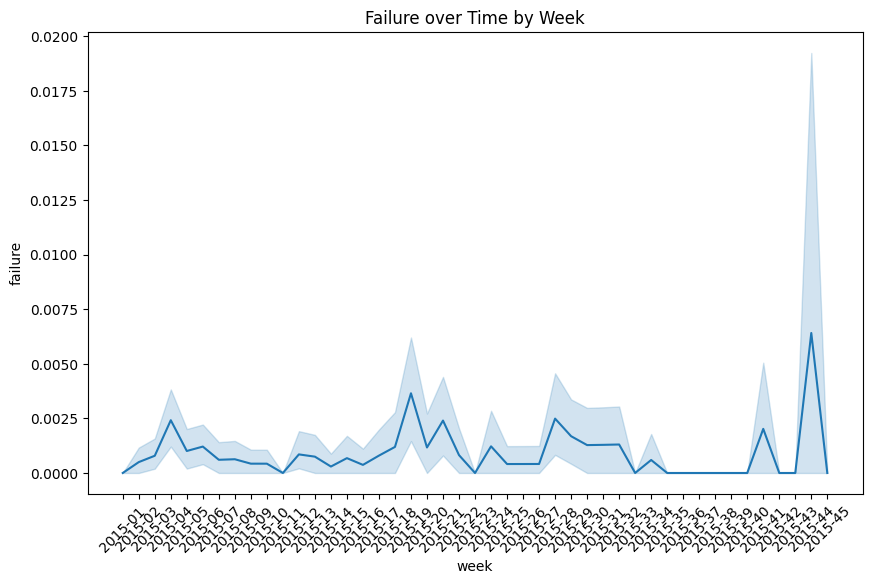

In [23]:

# Extract and format the 'week' column for plotting
df['week'] = df['date'].dt.to_period('W')
df['week'] = df['week'].dt.strftime('%Y-%U')

# Create a line plot to visualize 'failure' over time by week
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='week', y='failure')
plt.xticks(rotation=45)
plt.title("Failure over Time by Week")


Text(0.5, 1.0, 'Correlation Matrix')

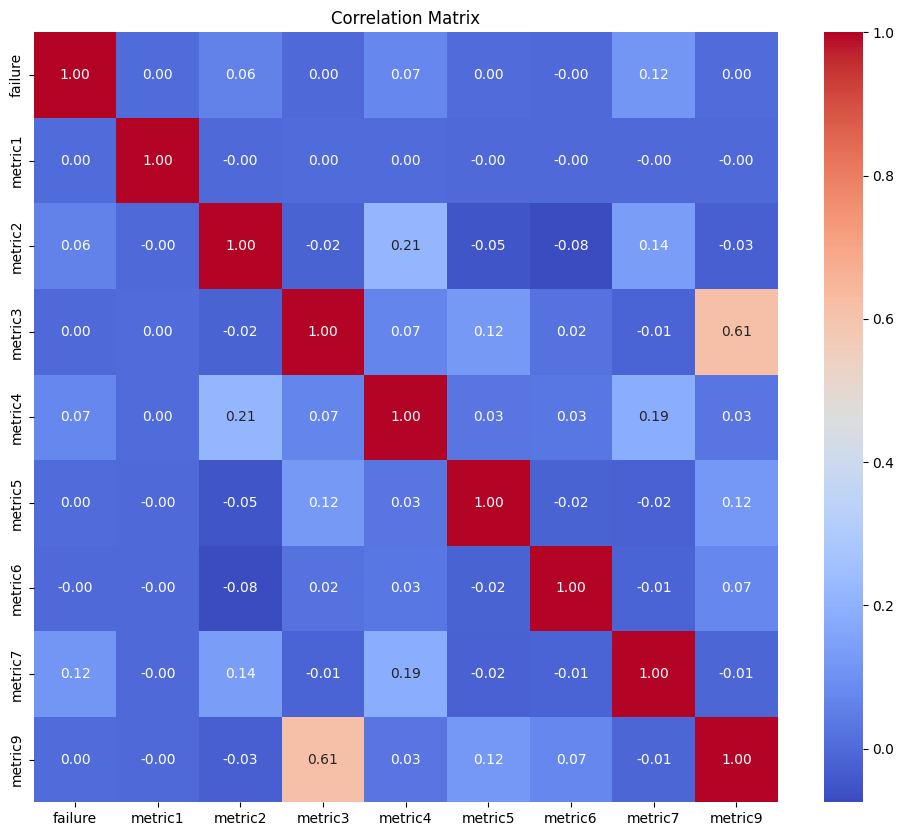

In [24]:

# Select only numeric columns for the correlation matrix
numeric_cols = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")


Since failure is generally zero looking to correlation would not be efficient.

Text(0.5, 1.0, "Distribution of 'failure'")

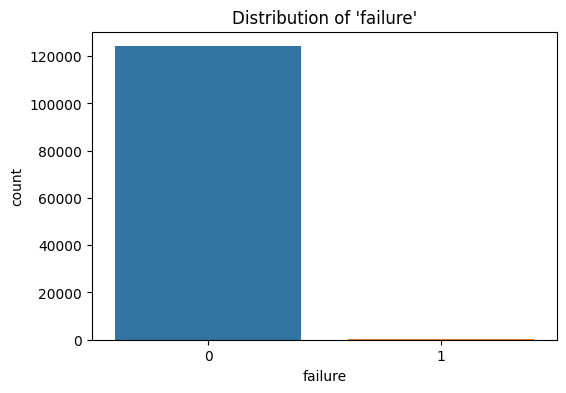

In [25]:

# Create a countplot to visualize the distribution of 'failure'
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='failure')
plt.title("Distribution of 'failure'")



So the problem is undersampling problem!

In [26]:

# Extract day of week, day of month, and is_weekend features from the 'date' column
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


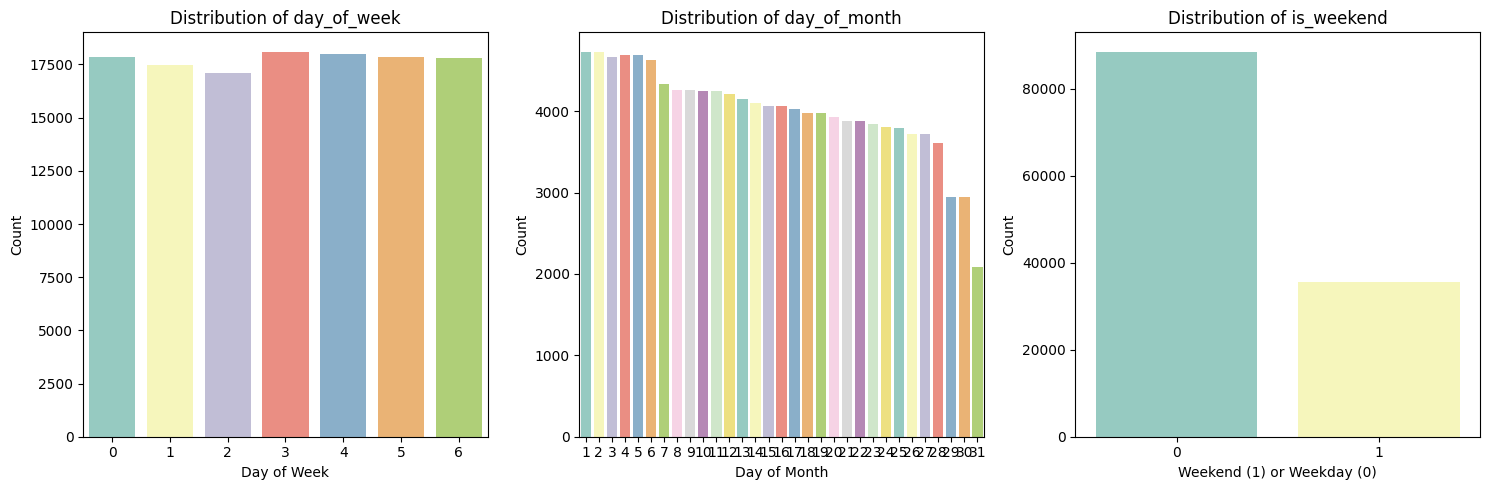

In [27]:

# Create subplots to visualize the distribution of day_of_week, day_of_month, and is_weekend
plt.figure(figsize=(15, 5))

# Distribution of 'day_of_week'
plt.subplot(131)
sns.countplot(data=df, x='day_of_week', palette='Set3')
plt.title("Distribution of day_of_week")
plt.xlabel("Day of Week")
plt.ylabel("Count")

# Distribution of 'day_of_month'
plt.subplot(132)
sns.countplot(data=df, x='day_of_month', palette='Set3')
plt.title("Distribution of day_of_month")
plt.xlabel("Day of Month")
plt.ylabel("Count")

# Distribution of 'is_weekend'
plt.subplot(133)
sns.countplot(data=df, x='is_weekend', palette='Set3')
plt.title("Distribution of is_weekend")
plt.xlabel("Weekend (1) or Weekday (0)")
plt.ylabel("Count")

# Show the subplots
plt.tight_layout()
plt.show()

In [28]:
# Extract the month number and week number from the 'date' column and drop the 'date' column
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week
df = df.drop(['date'], axis=1)

# Check the DataFrame information after these transformations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124242 entries, 0 to 124241
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   failure       124242 non-null  int64  
 1   metric1       124242 non-null  int64  
 2   metric2       124242 non-null  float64
 3   metric3       124242 non-null  float64
 4   metric4       124242 non-null  float64
 5   metric5       124242 non-null  int64  
 6   metric6       124242 non-null  int64  
 7   metric7       124242 non-null  float64
 8   metric9       124242 non-null  float64
 9   device_model  124242 non-null  object 
 10  month         124242 non-null  int32  
 11  week          124242 non-null  UInt32 
 12  day_of_week   124242 non-null  int32  
 13  day_of_month  124242 non-null  int32  
 14  is_weekend    124242 non-null  int64  
dtypes: UInt32(1), float64(5), int32(3), int64(5), object(1)
memory usage: 12.4+ MB


In [29]:
df=pd.get_dummies(df,drop_first=True)

In [30]:
#pip install imblearn

In [31]:
# Import the necessary library for undersampling
from imblearn.under_sampling import RandomUnderSampler



In [32]:
# Create a copy of the DataFrame 'df'
X = df.copy()

# Create the target variable 'Y' by selecting the 'failure' column
Y = df["failure"]

# Remove the 'failure' column from the feature matrix 'X'
X.drop("failure", axis=1, inplace=True)


In [33]:

# Create an instance of the RandomUnderSampler with a fixed random state
rus = RandomUnderSampler(random_state=42)

# Perform random under-sampling and obtain resampled feature matrix and target variable
X_resampled, y_resampled = rus.fit_resample(X, Y)


In [34]:

# Create a new DataFrame 'under_sample' by copying the resampled features and adding the 'failure' column back
under_sample = X_resampled.copy()
under_sample["failure"] = y_resampled


In [35]:

# Display a random sample of 10 rows from the under-sampled dataset
under_sample.sample(10)

metric1  metric2   metric3   metric4  metric5  metric6   metric7  \
19466   113336312      0.0  4.290459  0.000000       12   279722  0.000000   
23235   107483736      0.0  0.000000  0.000000        4   311012  0.000000   
56821   192488552      0.0  0.000000  3.091042       41   242150  2.197225   
105072  180159616      0.0  0.000000  0.000000        8   332740  0.000000   
68571   153729424      0.0  0.000000  0.000000       11   222498  0.000000   
42084   113624664      0.0  0.000000  0.000000       11   192032  0.000000   
78345   243261216      0.0  0.000000  0.000000       10   255731  0.000000   
83629   151755032      0.0  0.000000  1.098612        8   316174  0.000000   
118706   12540704      0.0  0.000000  0.000000        9   201837  0.000000   
16181    77877592      0.0  0.000000  0.000000       12   233238  0.000000   

         metric9  month  week  day_of_week  day_of_month  is_weekend  \
19466   7.048386      1     4            5            24           1   
23235   1.609438      1     5            3            29           0   
56821   2.397895      3    12            3            19           0   
105072  0.000000      7    30            1            21           0   
68571   0.000000      4    15            4            10           0   
42084   0.000000      2     9            2            25           0   
78345   1.386294      5    19            3             7           0   
83629   0.000000      5    21            3            21           0   
118706  0.693147      9    37            6            13           1   
16181   0.000000      1     4            0            19           0   

        device_model_S1F1  device_model_W1F0  device_model_W1F1  \
19466               False              False              False   
23235               False               True              False   
56821               False               True              False   
105072              False              False              False   
68571               False              False               True   
42084               False               True              False   
78345               False              False              False   
83629               False              False              False   
118706              False              False              False   
16181               False               True              False   

        device_model_Z1F0  device_model_Z1F1  failure  
19466               False              False        0  
23235               False              False        0  
56821               False              False        1  
105072               True              False        0  
68571               False              False        0  
42084               False              False        0  
78345               False              False        1  
83629               False              False        1  
118706               True              False        0  
16181               False              False        1

Text(0.5, 1.0, "Distribution of 'failure'")

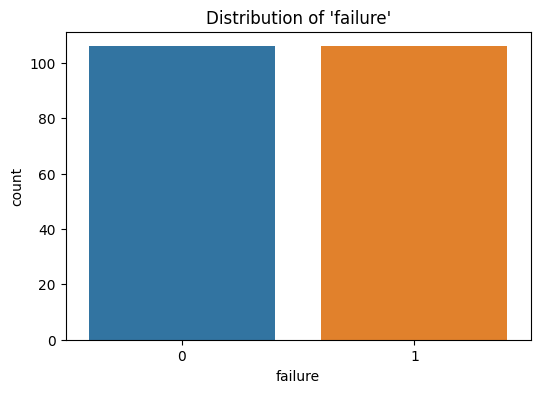

In [36]:

# Create a countplot to visualize the distribution of 'failure' in the under-sampled dataset
plt.figure(figsize=(6, 4))
sns.countplot(data=under_sample, x='failure')
plt.title("Distribution of 'failure'")


As we can see it is equal now.

In [37]:
# Import the necessary libraries for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create feature matrix 'X_norm' and target variable 'y_norm'
X_norm = under_sample.drop(['failure'], axis=1)
y_norm = under_sample['failure']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



In [38]:

# Import various classification algorithms and evaluation metrics
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a function to evaluate multiple classifiers and return a DataFrame with metrics
def evaluate_model(x_train, y_train, x_test, y_test):
    # Define a list of classifiers
    classifiers = [
        GradientBoostingClassifier(),
        RandomForestClassifier(),
        AdaBoostClassifier(),
        ExtraTreesClassifier(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(),
        GaussianNB(),
        BernoulliNB(),
        SVC(),
        LogisticRegression(),
        SGDClassifier(),
    ]

    # Define the names of classifiers
    classifier_names = [
        'GradientBoost',
        'RandomForest',
        'AdaBoost',
        'ExtraTrees',
        'DecisionTree',
        'KNeighbors',
        'GaussianNB',
        'BernoulliNB',
        'SVC',
        'LogisticRegression',
        'SGD',
    ]

    # Create an empty DataFrame for metrics
    metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=classifier_names)

    # Evaluate each classifier and store the metrics
    for i, clf in enumerate(classifiers):
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        metrics.loc[classifier_names[i], 'Accuracy'] = accuracy
        metrics.loc[classifier_names[i], 'Precision'] = precision
        metrics.loc[classifier_names[i], 'Recall'] = recall
        metrics.loc[classifier_names[i], 'F1'] = f1

    # Sort the metrics by accuracy in descending order
    metrics = metrics.sort_values(by='Accuracy', ascending=False)

    return metrics

# Step 4: Evaluate models
metrics = evaluate_model(x_train, y_train, x_test, y_test)

In [39]:
metrics

Accuracy Precision    Recall        F1
AdaBoost            0.906977  0.916667  0.916667  0.916667
SVC                 0.883721       1.0  0.791667  0.883721
GradientBoost       0.860465  0.909091  0.833333  0.869565
GaussianNB          0.860465      0.95  0.791667  0.863636
RandomForest        0.837209  0.904762  0.791667  0.844444
ExtraTrees          0.837209  0.869565  0.833333  0.851064
LogisticRegression  0.837209  0.947368      0.75  0.837209
BernoulliNB         0.813953       0.9      0.75  0.818182
SGD                 0.813953  0.944444  0.708333  0.809524
DecisionTree        0.767442      0.85  0.708333  0.772727
KNeighbors          0.767442    0.9375     0.625      0.75

I will search hyper parameters for only  models which is around 65 F1 score

In [40]:
#pip install optuna

In [41]:
import optuna

# GradientBoosting

In [42]:
def objective_gb(trial):
    # Define hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
    }

    # Initialize the classifier with hyperparameters
    clf = GradientBoostingClassifier(**params, random_state=42)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [43]:
def create_study(objective):
    # Create an Optuna study

    # Set logging level to WARNING to suppress unnecessary output
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='maximize')  # We want to maximize accuracy

    # Run the optimization
    study.optimize(objective, n_trials=100)  # You can adjust the number of trials

    # Get the best hyperparameters from the study
    best_params = study.best_params
    best_f1 = study.best_value
    print(f'Best hyperparameters: {best_params}')
    print(f'Best f1 score: {best_f1}')
    return best_params

In [44]:
best_params=create_study(objective_gb)
best_gb = GradientBoostingClassifier(**best_params, random_state=42)
y_pred_gb=best_gb.fit(x_train, y_train).predict(x_test)


Best hyperparameters: {'n_estimators': 340, 'learning_rate': 0.1357070671708945, 'max_depth': 3, 'min_samples_split': 0.4466278336015183}
Best f1 score: 0.8979591836734694


# RandomForest

In [45]:
def objective_rf(trial):
    # Define the hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_uniform('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_uniform('min_samples_leaf', 0.1, 0.5)
    max_features = trial.suggest_categorical('max_features', ['log2', 'sqrt'])  # Only suggest valid options
    
    # Create and train the RandomForestClassifier with the suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [46]:
best_params=create_study(objective_rf)
best_rf = RandomForestClassifier(**best_params, random_state=42)
y_pred_rf=best_rf.fit(x_train, y_train).predict(x_test)


Best hyperparameters: {'n_estimators': 29, 'max_depth': 32, 'min_samples_split': 0.4079935321333394, 'min_samples_leaf': 0.10134513826139518, 'max_features': 'log2'}
Best f1 score: 0.8695652173913043


# AdaBoost

In [47]:
# Define the objective function for Optuna
def objective_ab(trial):
    # Define the hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 200)  # Number of weak learners
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0)  # Learning rate
    algorithm = trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])  # AdaBoost algorithm

    # Create an AdaBoostClassifier with the suggested hyperparameters
    model = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm=algorithm,
        random_state=42
    )

    # Train the model
    model.fit(x_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(x_test)

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [48]:
best_params=create_study(objective_ab)
best_ab = AdaBoostClassifier(**best_params, random_state=42)
y_pred_ab=best_ab.fit(x_train, y_train).predict(x_test)


Best hyperparameters: {'n_estimators': 101, 'learning_rate': 0.7379844029934256, 'algorithm': 'SAMME.R'}
Best f1 score: 0.9166666666666666


# ExtraTrees

In [49]:
import optuna
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

def objective_etc(trial):
    # Define the hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 32)
    min_samples_split = trial.suggest_float("min_samples_split", 0.1, 1.0)
    min_samples_leaf = trial.suggest_float("min_samples_leaf", 0.1, 0.5)

    # Create an ExtraTrees classifier with the suggested hyperparameters
    clf = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42  # You can set a random seed for reproducibility
    )

    # Fit the classifier on the training data
    clf.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(x_test)

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1



In [50]:
best_params=create_study(objective_etc)
best_etc = ExtraTreesClassifier(**best_params, random_state=42)
y_pred_etc=best_etc.fit(x_train, y_train).predict(x_test)


Best hyperparameters: {'n_estimators': 370, 'max_depth': 9, 'min_samples_split': 0.18702383575345394, 'min_samples_leaf': 0.1088163383388843}
Best f1 score: 0.8695652173913043


# Decision Tree

In [51]:
# Define the objective function to optimize
def objective_dt(trial):
    # Define hyperparameters to search and their respective ranges
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_uniform('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_uniform('min_samples_leaf', 0.1, 0.5)

    # Create a DecisionTree classifier with the suggested hyperparameters
    clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42  # Set a random state for reproducibility
    )

    # Fit the classifier on the training data
    clf.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(x_test)

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1



In [52]:
best_params=create_study(objective_dt)
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
y_pred_dt=best_dt.fit(x_train, y_train).predict(x_test)


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 0.8594677245540513, 'min_samples_leaf': 0.35857503196546225}
Best f1 score: 0.7017543859649124


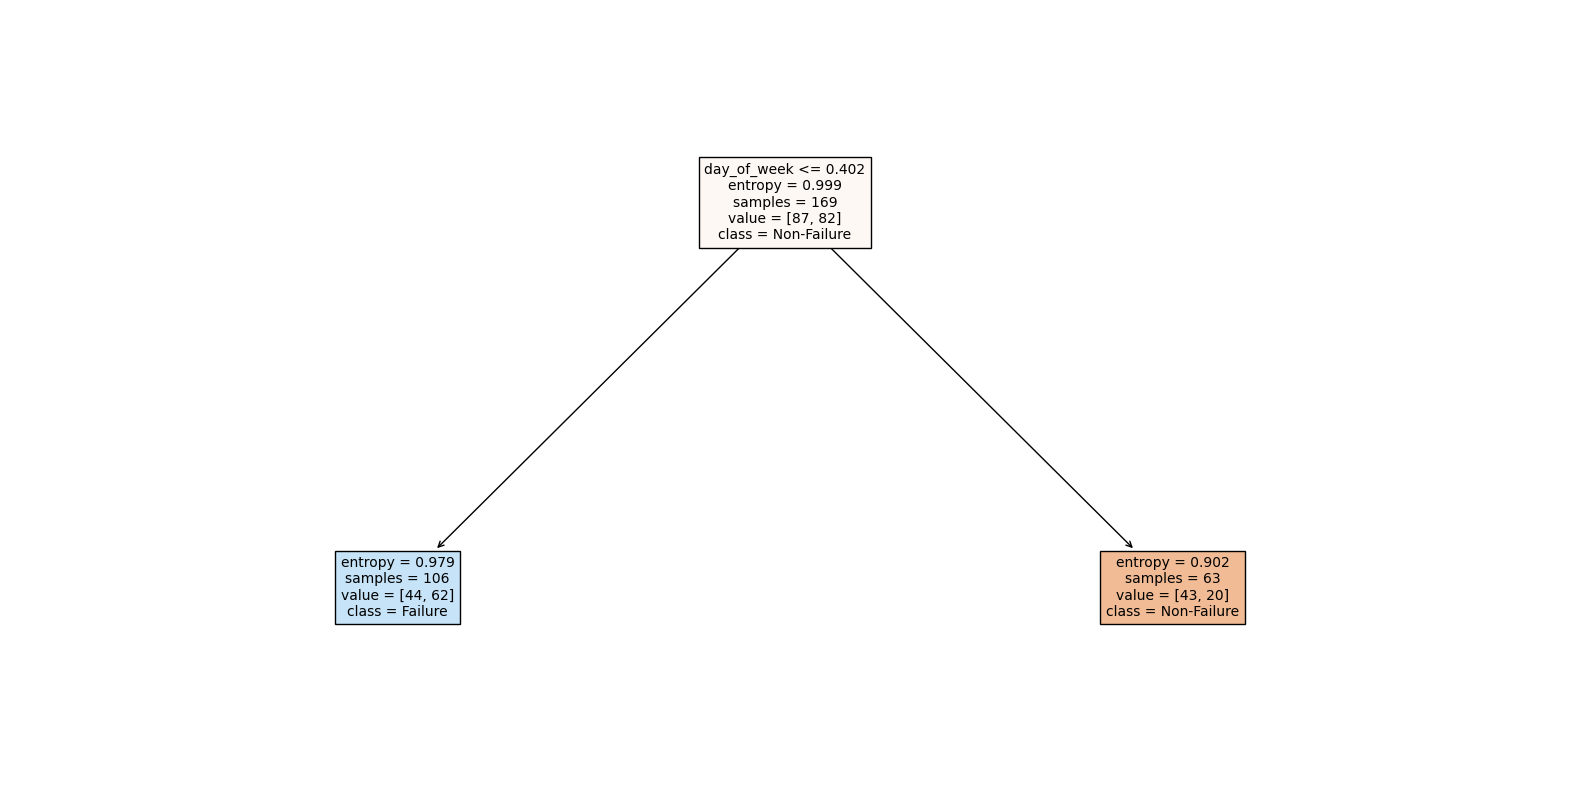

In [53]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=df.drop("failure",axis=1).columns.to_list(), class_names=["Non-Failure", "Failure"], filled=True, fontsize=10)
plt.show()


# KNN

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import optuna

def objective_knn(trial):
    # Define hyperparameters to optimize
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),  # p=1 for Manhattan distance, p=2 for Euclidean distance
    }

    # Initialize the classifier with hyperparameters
    clf = KNeighborsClassifier(**params)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)    

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1


In [55]:
best_params=create_study(objective_knn)
best_knn = KNeighborsClassifier(**best_params)
y_pred_knn=best_knn.fit(x_train, y_train).predict(x_test)


Best hyperparameters: {'n_neighbors': 12, 'weights': 'distance', 'p': 2}
Best f1 score: 0.8


# GaussianNB

In [56]:
best_gnb = GaussianNB()
y_pred_gnb=best_gnb.fit(x_train, y_train).predict(x_test)


# BernoulliNB

In [57]:
def objective_bnb(trial):
    # Define hyperparameters to optimize
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-10, 1.0),
        'binarize': trial.suggest_float('binarize', 0.0, 1.0),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False]),
    }

    # Initialize the classifier with hyperparameters
    clf = BernoulliNB(**params)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)
    

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [58]:
best_params=create_study(objective_bnb)
best_bnb = BernoulliNB(**best_params)
y_pred_bnb=best_bnb.fit(x_train, y_train).predict(x_test)


Best hyperparameters: {'alpha': 0.004584081413512202, 'binarize': 0.7822257487195048, 'fit_prior': True}
Best f1 score: 0.8837209302325582


# SVC

In [59]:
def objective_svc(trial):
    # Define hyperparameters to optimize
    params = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 2, 5) if trial.params['kernel'] == 'poly' else 1,
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']) if trial.params['kernel'] in ['rbf', 'poly', 'sigmoid'] else 'scale',
    }

    # Initialize the classifier with hyperparameters
    clf = SVC(**params, random_state=42)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)
    
    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1


In [60]:
best_params=create_study(objective_svc)
best_svc = SVC(**best_params)
y_pred_svc=best_svc.fit(x_train, y_train).predict(x_test)


Best hyperparameters: {'C': 1.2373765957712888, 'kernel': 'rbf', 'gamma': 'auto'}
Best f1 score: 0.8837209302325582


# LogisticRegression

In [61]:
def objective_lr(trial):
    # Define hyperparameters to optimize
    params = {
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
    }

    # Initialize the classifier with hyperparameters
    clf = LogisticRegression(**params, random_state=42)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)
    
    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [62]:
best_params=create_study(objective_lr)
best_lr = LogisticRegression(**best_params)
y_pred_lr=best_lr.fit(x_train, y_train).predict(x_test)


Best hyperparameters: {'C': 370.36312813086556, 'solver': 'lbfgs'}
Best f1 score: 0.8372093023255814


# SGDClassifier

In [63]:
def objective_sgd(trial):
    # Define hyperparameters to optimize
    params = {
        'loss': trial.suggest_categorical('loss', ['hinge', 'log', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'alpha': trial.suggest_loguniform('alpha', 1e-6, 1e-1),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'eta0': trial.suggest_loguniform('eta0', 1e-5, 1e-1),
    }

    # Initialize the classifier with hyperparameters
    clf = SGDClassifier(**params, random_state=42)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)
    
    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [64]:
best_params=create_study(objective_sgd)
best_sgd = SGDClassifier(**best_params)
y_pred_sgd=best_sgd.fit(x_train, y_train).predict(x_test)


Best hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.007683168989694206, 'learning_rate': 'invscaling', 'eta0': 2.5395401032971784e-05}
Best f1 score: 0.8695652173913043


# Voting Classifier

In [65]:
from sklearn.ensemble import VotingClassifier


In [66]:
# Create a Voting Classifier
voting_clf = VotingClassifier(estimators=[('gb', best_gb), ('rf', best_rf), ('ab', best_ab), ('etc', best_etc), ('dt', best_dt), ('knn', best_knn), ('gnb', best_gnb), ('bnb', best_bnb), ('svc', best_svc), ('lr', best_lr), ('sgd', best_sgd)], voting='hard')

# Train the Voting Classifier on the training data
voting_clf.fit(x_train, y_train)

# Make predictions on the test data
y_pred_vh = voting_clf.predict(x_test)

## Comparing Models


Model: Model Gradient Boosting
Precision: 0.8800
Recall: 0.9167
F1 Score: 0.8980
Accuracy: 0.8837

Model: Model Random Forest
Precision: 0.9091
Recall: 0.8333
F1 Score: 0.8696
Accuracy: 0.8605

Model: Model AdaBoost
Precision: 0.9167
Recall: 0.9167
F1 Score: 0.9167
Accuracy: 0.9070

Model: Model Extra Tree
Precision: 0.9091
Recall: 0.8333
F1 Score: 0.8696
Accuracy: 0.8605

Model: Decison Tree
Precision: 0.6061
Recall: 0.8333
F1 Score: 0.7018
Accuracy: 0.6047

Model: KNN
Precision: 1.0000
Recall: 0.6667
F1 Score: 0.8000
Accuracy: 0.8140

Model: GaussianNB
Precision: 0.9500
Recall: 0.7917
F1 Score: 0.8636
Accuracy: 0.8605

Model: BernoulliNB
Precision: 1.0000
Recall: 0.7917
F1 Score: 0.8837
Accuracy: 0.8837

Model: SVC
Precision: 1.0000
Recall: 0.7917
F1 Score: 0.8837
Accuracy: 0.8837

Model: LogisticRegression
Precision: 0.9474
Recall: 0.7500
F1 Score: 0.8372
Accuracy: 0.8372

Model: SGDClassifier
Precision: 0.9000
Recall: 0.7500
F1 Score: 0.8182
Accuracy: 0.8140

Model: Hard Voting Cl

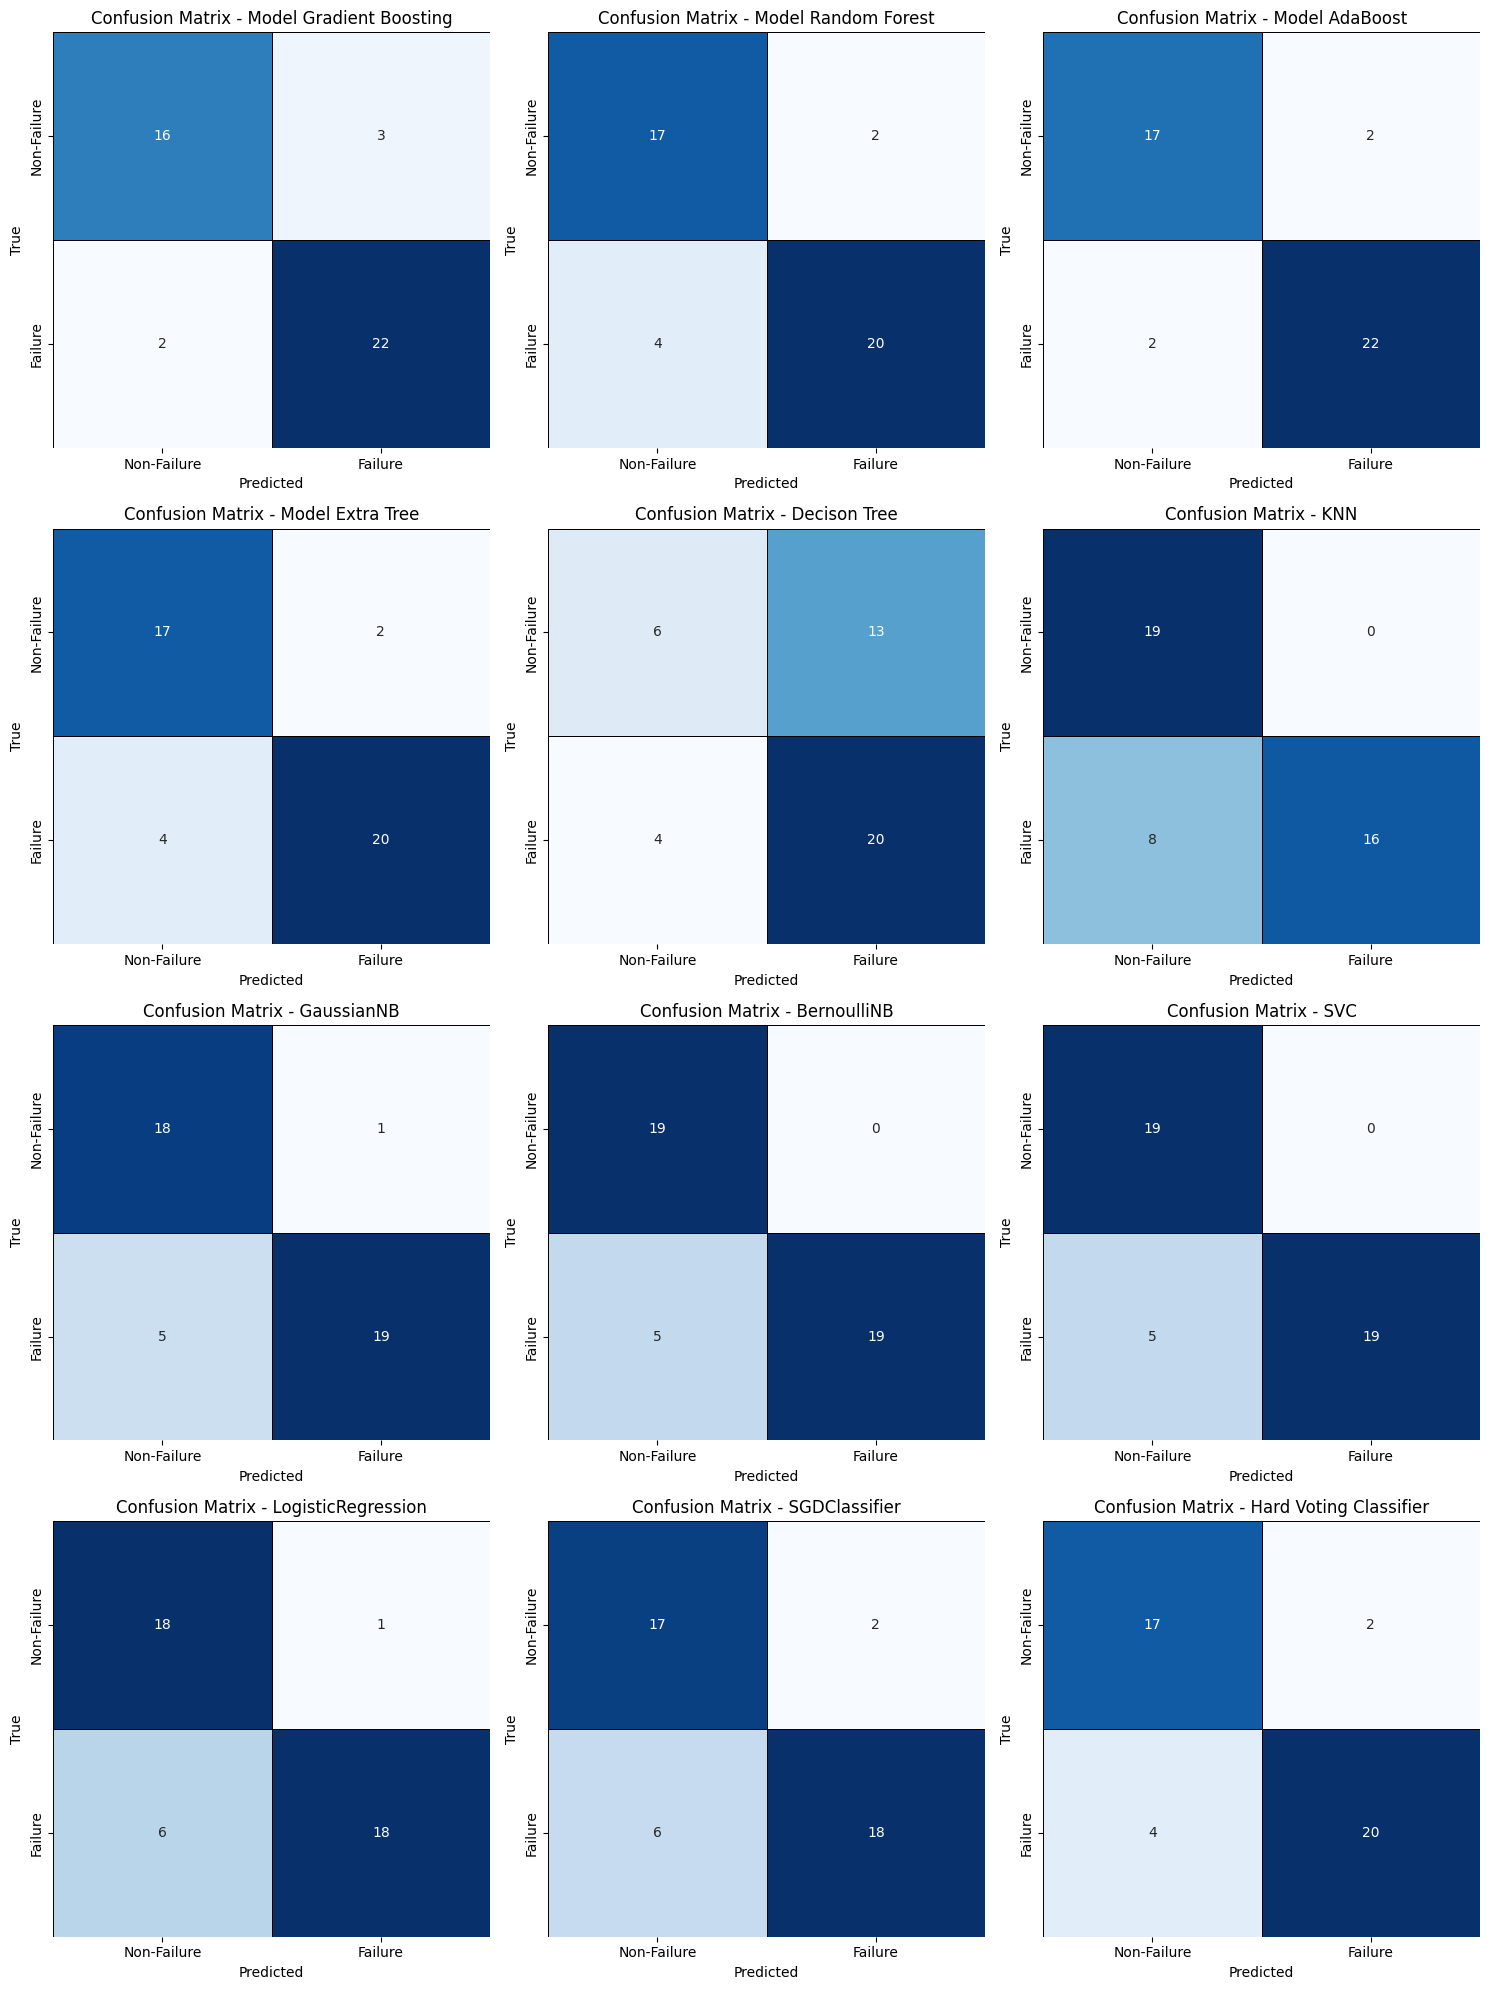


=====Best Model=====

Model: Model AdaBoost
Precision: 0.9167
Recall: 0.9167
F1 Score: 0.9167
Accuracy: 0.9070


In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Function to calculate evaluation metrics
def calculate_evaluation_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return precision, recall, f1, accuracy
def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black", cbar=False, xticklabels=["Non-Failure", "Failure"], yticklabels=["Non-Failure", "Failure"], ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
# Initialize variables to store best metrics
best_model = ""
best_f1 = 0.0
best_precision = 0.0
best_recall = 0.0
best_accuracy = 0.0

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(3*5, 4*5))

# Plot each confusion matrix and find the best model
models = [
    ("Model Gradient Boosting", y_pred_gb),
    ("Model Random Forest", y_pred_rf),
    ("Model AdaBoost", y_pred_ab),
    ("Model Extra Tree", y_pred_etc),
    ("Decison Tree", y_pred_dt),
    ("KNN", y_pred_knn),
    ("GaussianNB", y_pred_gnb),
    ("BernoulliNB",y_pred_bnb),
    ("SVC", y_pred_svc),
    ("LogisticRegression", y_pred_lr),
    ("SGDClassifier", y_pred_sgd),
    ("Hard Voting Classifier", y_pred_vh),
]

for (model_name, y_pred), ax in zip(models, axes.flatten()):
    plot_confusion_matrix(ax, y_test, y_pred, f"Confusion Matrix - {model_name}")
    
    # Calculate evaluation metrics
    precision, recall, f1, accuracy = calculate_evaluation_metrics(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"\nModel: {model_name}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # Update best model if current model has higher F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_model = model_name
        best_precision = precision
        best_recall = recall
        best_accuracy = accuracy



# Adjust layout
plt.tight_layout()
plt.show()

# Print the best model
print("\n=====Best Model=====\n")
print(f"Model: {best_model}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1 Score: {best_f1:.4f}")
print(f"Accuracy: {best_accuracy:.4f}")

AUC: 0.9057017543859649


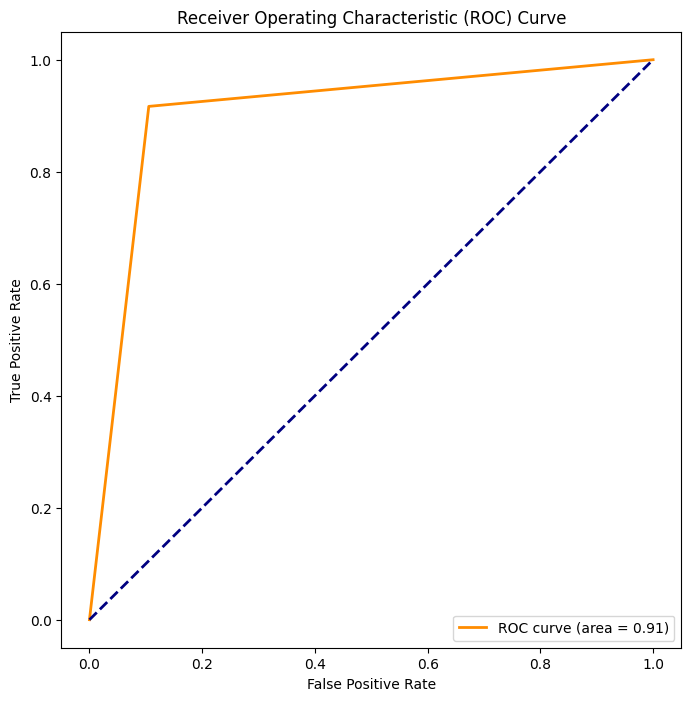

In [68]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ab)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
